# 신경망 학습

학습이란 훈련 데이터로부터 가중치 매개변수의 최적값을 자동으로 흭득하는 것을 의미한다.

기계학습 문제는 데이터를 **훈련 데이터(training data)**와 **시험 데이터(test data)**로 나눠 학습과 시험을 수행하는 것이 일반적입니다.

보통의 진행은 훈련 데이터만 사용하여 학습하면서 최적의 매개변수를 찾습니다. 그 후 시험 데이터를 사용하여 앞서 훈련한 모델의 실력을 평가합니다.

이를 하는 이유는 **범용 능력**을 제대로 평가하기 위함입니다.
**범용 능력** : 학습 하지 못한 데이터도 올바르게 푸는 능력

하지만 그렇다고 한 데이터셋으로만 지나치게 최적화 되면 **오버피팅**이라는 문제가 생깁니다.

## 손실함수

성능의 '나쁨'을 나타내는 지표로 일반적으로 평군 제곱 오차와 교차 엔트로피 오차를 사용

### 평균 제곱 오차  

E = 1/2 * (sum(yk -tk) ** 2)  
yk = 신경망의 출력  
tk = 정답 레이블  
k는 데이터의 차원 수를 나타냄

In [4]:
import numpy as np

In [5]:
def mean_squared_error(y, k):
    return 0.5 * np.sum((y-k)**2)

In [3]:
t = [0,0,1,0,0,0,0,0,0,0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]

In [8]:
mean_squared_error(np.array(y), np.array(t))

0.09750000000000003

### 교차 엔트로피 오차  
  
E = -(sum(tk * log yk))  
yk = 신경망의 출력  
tk = 정답 레이블(one-hot-encoding)

사실상 정답 레이일 때로 추정되면 자연로그를 계산하는 방식

In [9]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

아주 작은 값인 delta를 더하는 이유는 np.log()에 0을 입력하면 -inf가 출력된다.  
이를 방지하기 위함

In [10]:
np.log(0)

<ipython-input-10-f6e7c0610b57>:1: RuntimeWarning: divide by zero encountered in log
  np.log(0)


-inf

In [12]:
cross_entropy_error(np.array(y),np.array(t))

0.510825457099338

In [14]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]

cross_entropy_error(np.array(y),np.array(t))

2.302584092994546

정답일 시 출력되는 값이 더 낮다.  
기계학습은 훈련 데이터에 대한 손실 함수의 값을 구해서 매개변수를 정정한다.  
만약 100개의 훈련 데이터가 존재 한다면 각각 손실 함수를 구한 후 그 값의 합을 지표로 삼는다.

### 손실 함수의 합

교차 엔트로피 오차의 합 식  
E = -(1/N * sum(sum(tnk * log ynk)))  

N = 데이터의 갯수  
tnk = n번째 데이터의 k번째 값

### 미니배치

모든 데이터의 손실함수 값의 합을 구하는 것은 힘든다.(배치의 양이 너무 크다.)  
그렇기 때문에 훈련 데이터의 일부만 골라 추정치를 구한다.(일부만 뽑는다.)

MNIST를 이용한 미니배치 학습 예제

In [ ]:
import sys, os
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_size = x_train.shape[0] # 60000
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size) # 트레이닝 데이터 중 batch_size만큼을 뽑는다.
x_batch = x_train[batch_mask]
y_batch = y_train[batch_mask]

데이터 하나당 교차 엔트로피 오차를 구하는 교차 엔트로피 오차 구현

In [ ]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = t.reshape(1, y.size)
        
    batch_size = y.shpae[0]
    return -np.sum(np.log(y[np.arang(batch_size), t] + 1e - 7)) / batch_size

## 손실함수를 사용하는 이유  
  
정확도나 계단 함수를 사용하면 가중치의 작은 변화에 따른 연속적인 변화가 나타나지 않는다.  
하지만 시그모이드 함수와 같은 손실 함수는 작은 가중치 변화에도 연속적인 변화가 나타난ㄷ.  
시그모이드의 함수의 미분은 어느 장소라도 0이 되지는 않는다.

## 경사법(경사 하강법)

현 위치에서 기울어진 방향으로 일정 거리만큼 이동하고 그 곳에서 기울기를 구해서 나아가는 식으로 반복해 함수의 값을 점차 줄이는 방법

**기울기** : 기울기가 가리키는 쪽은 각 장소에서 함수의 출력 값을 가장 크게 줄이는 방향이다.  
기울기를 이용하여 함수의 최솟값을 찾고자 하는 방법  

함수가 극솟값, 최소값, 안장점일 시 기울기는 0이다.  
극솟값 : 한정된 범위에서의 최솟값인 점  
안장점 : 어느 방향에서 보면 극댓값이고 다른 방향에서 보면 극솟값이 되는 점  

주의할점은 기울기가 가리키는 곳이 꼭 최솟값이라는 보장이 없다. 또, 복잡하고 찌그러진 모양의 함수라면 평평한 곳으로 파고들면서 **Plateau**라 하느, 학습이 진행되지 않는 정체기에 빠질 수 있다.  
하지만 기울기가 가리키는 방향으로 나아가야 함수의 값을 줄일 수 있어서 이 정보를 단서로 나아갈 방향을 정해야 한다.

*최솟값을 찾으면 경사 하강법, 최댓값을 찾으면 경사 상승법*

경사법의 수식  
x = x - η * (af / ax0)  

η(eta) = 갱신하는 양(학습률)  

보통 η값을 미리 정해두는데 너무 크거나 작으면 '좋은 장소'를 찾아갈 수 없다. 신경망 학습에서는 보통 이 η값을 변경하면서 올바르게 학습하고 있는지를 확인하면서 진행

In [19]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)

In [15]:
def numerical_gradient(f, x):#기울기 구하는 함수
    h = 1e-4
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_var = x[idx] 
        
        x[idx] = tmp_var + h #f(x+h)계산
        fxh1 = f(x)
        
        x[idx] = tmp_var - h #f(x-h)계산
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2 * h)
        x[idx] = tmp_var # 값 복원
        
    return grad

경사법으로 f(x0, x1) = x0** 2 + x1** 2의 최솟값 구하기

In [20]:
def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])
x, x_history = gradient_descent(function_2, init_x = init_x, lr = 0.1, step_num = 100)

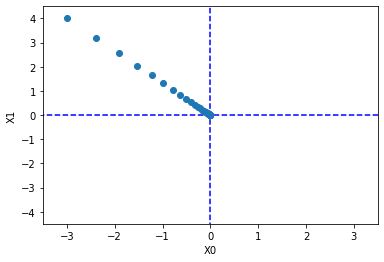

In [21]:
plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

학습률이 너무 큰 예

In [22]:
def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])
x, x_history = gradient_descent(function_2, init_x = init_x, lr = 10.0, step_num = 100)

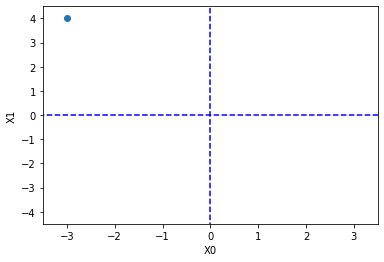

In [23]:
plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

큰 값을 발산해버린다.

학습률이 너무 작은 예

In [25]:
def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])
x, x_history = gradient_descent(function_2, init_x = init_x, lr = 1e-10, step_num = 100)

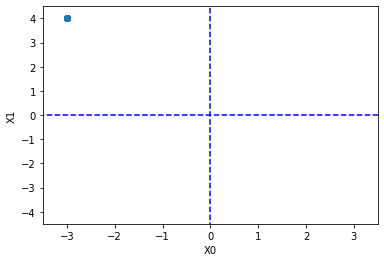

In [26]:
plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

거의 갱신되지 않고 끝난다.

**하이퍼파라미터(초매개변수)** : 학습률 같은 매개변수를 의미  
가중치와 편향 같은 신경망의 매개변수와는 성질이 다른 매개변수이다.  
신경망의 가중치 매개변수는 훈련 데이터와 학습 알고리즘에 의해서 '자동'으로 흭득되는 매개변수인 반면, 학습률 같은 하이퍼파라미터는 사람이 직접 서렂애향 하는 매개변수이다.이 하이퍼파라미터들은 여러 후보 값 중에서 시험을 통해 가장 잘 학습하는 값을 찾는 과정을 거쳐야 한다.

## 학습 알고리즘 구현하기

In [9]:
import sys, os
import numpy as np

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        
        #가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.parmas['b1'], self.params['b2']
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y

    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        t = np.argmax(t, axis = 1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exe(-x))

In [11]:
import math

def sofrtmax(x):
    c = np.max(x)
    exp_a = np.exp(x - c)
    sum_exp = np.sum(exp_a)
    y = exp_a / sum_exp
    
    return y

In [12]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

In [13]:
net = TwoLayerNet(input_size=784, hidden_size = 100, output_size = 10)
net.params['W1'].shape
net.params['b1'].shape
net.params['W2'].shape
net.params['b2'].shape

(10,)

In [ ]:
def numeri

## 시험 데이터 평가하기

In [16]:
from dataset.mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label = True)

network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.numerical_gradient(x_batch, t_batch)
    
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc : " + str(train_acc) + ", " + str(test_acc))

AttributeError: 'TwoLayerNet' object has no attribute 'parmas'